In [1]:
import cv2 as cv
from cv2 import aruco
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_mean_corners(corners):
    corner_means = []
    for i in range(len(corners)):
        c = corners[i][0]
        cm = [c[:, 0].mean()], [c[:, 1].mean()]
        corner_means.append(cm)
    return np.array(corner_means).squeeze()


def get_sorted_corner_means(ids, corners):
    get_mean_corners(corners), ids
    concatar = np.hstack((ids, get_mean_corners(corners)))
    sortedarr = concatar[concatar[:, 0].argsort()]
    return sortedarr[:, 1:3]

In [3]:
# Set minimum and maximum HSV values to display
# lower = np.array([hMin, sMin, vMin])
# upper = np.array([hMax, sMax, vMax])
lower_g = np.array([60, 100, 40])
upper_g = np.array([80, 255, 100])
lower_r = np.array([150, 130, 30])
upper_r = np.array([179, 255, 90])

green_bound_tuple = (lower_g, upper_g)
red_bound_tuple = (lower_r, upper_r)

In [4]:
# specifiy here: red or green
color_bounds = green_bound_tuple

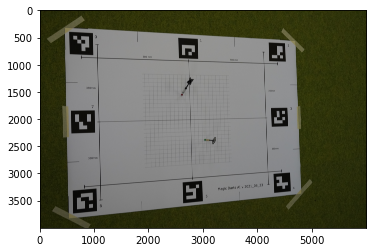

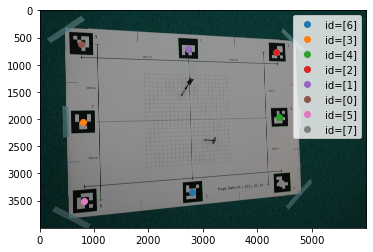

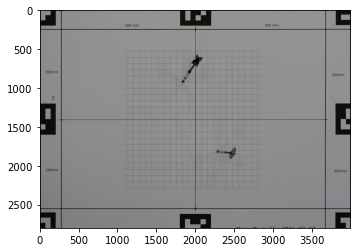

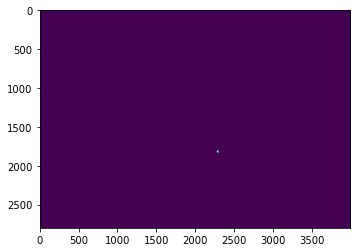

In [5]:
# read image
image = cv.imread('input.jpg')
plt.figure()
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.show()
# find markers
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(
    gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(image.copy(), corners, ids)
# show markers
plt.figure()
plt.imshow(frame_markers)
for i in range(len(ids)):
    c = corners[i][0]
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()],
             "o", label="id={0}".format(ids[i]))
plt.legend()
plt.show()
# get sorted corners
clw_sorted_corners = get_sorted_corner_means(ids, corners)
# define ground truth marker points
zoom_ = 4
dest_corners = zoom_*np.array([[0, 0], [500, 0], [1000, 0],
                              [0, 350], [1000, 350], [0, 700], [500, 700], [1000, 700]])
dest_width = zoom_*1000
dest_height = zoom_*700
# find homography
h, mask = cv.findHomography(clw_sorted_corners, dest_corners, cv.RANSAC)
# 'rectify' image
warp_img = cv.warpPerspective(image, h, (dest_width, dest_height))
plt.figure()
plt.imshow(cv.cvtColor(warp_img, cv.COLOR_BGR2RGB))
cv.imwrite('warpimg.jpg', warp_img)
plt.show()
# detect darts
# Set minimum and maximum HSV values to display
# lower = np.array([hMin, sMin, vMin])
# upper = np.array([hMax, sMax, vMax])
lower, upper = color_bounds
# Convert to HSV format and color threshold
hsv = cv.cvtColor(warp_img, cv.COLOR_BGR2HSV)
mask = cv.inRange(hsv, lower, upper)
result = cv.bitwise_and(warp_img, warp_img, mask=mask)
result_gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
_, dst = cv.threshold(result_gray, 10, 255, 0)
plt.imshow(dst)
plt.show()

In [6]:
dart_positions = np.argwhere(mask>200)
dart_positions

array([[1802, 2288],
       [1802, 2289],
       [1802, 2290],
       ...,
       [1831, 2291],
       [1831, 2292],
       [1831, 2293]])

In [7]:
dart_mean_pos = np.array([dart_positions[:,0].mean(), dart_positions[:,1].mean()])
dart_mean_pos

array([1816.45350734, 2286.5725938 ])

In [8]:
img_size_px = dest_corners[-1]
img_size_mm = dest_corners[-1]/zoom_
mm_per_pixel = img_size_mm/img_size_px
mm_per_pixel

array([0.25, 0.25])

In [9]:
pos = dart_mean_pos/zoom_
pos # in mm

array([454.11337684, 571.64314845])

In [10]:
# pos green dart in mm: array([454.11337684, 571.64314845])
# pos red dart in mm: array([229.12409289, 459.95137881])

In [11]:
# transform to center coordinate system
offset_center = np.array([350, 500])

In [12]:
pos_c = pos - offset_center
pos_c # in mm

array([104.11337684,  71.64314845])